# Модель машиннго обучения - StackingRegressor()_2!!!

In [9]:
# загружаем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # библиотека для научных вычислений в python / the fundamental package for scientific computing with python
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library

from sklearn.linear_model import LinearRegression # алгоритм линейной регрессии
from sklearn.linear_model import ElasticNet # алгоритм линейной регрессии с регуляризацией L1, L2 / elasticnet regression regularization L1, L2
from sklearn.linear_model import RidgeCV # алгоритм регуляризации
from sklearn.tree import DecisionTreeRegressor # регрессор дерева решений
from sklearn.ensemble import RandomForestRegressor # алгоритм случайный лес для задач регрессии
from sklearn.ensemble import ExtraTreesRegressor # модель случайного леса / random forest
from sklearn.ensemble import StackingRegressor # алгоритм стекинга
from sklearn.ensemble import GradientBoostingRegressor # алгоритм градиентного бустинга для задач регрессии

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split
from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  
from sklearn.preprocessing import MinMaxScaler # алгоритм стандартизации данных / MinMaxScaler

from joblib import dump, load # сохранение и загрузка модели 
from colorama import Fore, Back, Style # цветовая палитра


from xgboost import XGBRegressor # модель XGBoost Regressor / model XGBoost Regressor
from catboost import CatBoostRegressor # алгоритм экстремального градиентного бустинга для регрессии из библиотеки catboost 

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

In [10]:
# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
model_results = []

In [11]:
# описываем функцию для вывода результатов score для train, valid и test
def results_model(model, model_name):
    """Функция для вывода результатов score для train, valid и test,  
    а также для сохранения этих значений для последующего использования
    Args:
      model (model): Ссылка на обучепнную модель
      model_name (string): Название примененной модели
    """
  
    y_train_pred = model.predict(X_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
    MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred)*100).round(3)
  
    print(f"Тренировочная выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_train:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_train:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_train:.2f}{Fore.RESET}%")
  
    y_valid_pred = model.predict(X_valid)
    RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
    MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
    MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred)*100).round(3)
  
    print(f"Валидная выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_valid:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_valid:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_valid:.2f}{Fore.RESET}%")
  
    y_test_pred = model.predict(X_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
    MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
    MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred)*100).round(3)
  
    print(f"Тестовая выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_test:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_test:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_test:.2f}{Fore.RESET}%") 
  
    model_results.append({"RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
                        "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
                        "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
                        'ML_model': model_name})

In [12]:
%%time
# загружаем данные
data = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data.drop(columns="target", axis=1)
y = data["target"]

# производим разделение выборки на тренировочную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

feature_names = X_train.columns.tolist()

# производим нормализацию обучающей и тестовой выборки с помощью MinMaxScaller
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

# загружаем модель
model_lr = load("model/model_LinearRegression.joblib")
model_elnet = load("model/model_ElasticNetOptuna.joblib")
model_etr = load("model/model_ExtraTreesRegressor.joblib")
model_gbr = load("model/model_GradientBoostingRegressorOptuna.joblib")
model_rfr = load("model/model_RandomForestRegressor.joblib")
model_cbr = load("model/model_CatBoostOptuna.joblib")
model_dtr = load("model/model_DecisionTreeRegressorHyperopt.joblib")
model_xgb = load("model/model_XGBoostOptuna.joblib")

# cоздаем список кортежей вида: (наименование модели, модель)
estimators = [
    ("lr", model_lr),
    ("elnet", model_elnet),
    ("etr", model_etr),
    ("gbr", model_gbr),
    ("rfr", model_rfr),
    ("cbr", model_cbr), 
    ("dtr", model_dtr)
]

# cоздаем объект класса стекинг
model_sr_2 = StackingRegressor(
    estimators=estimators, # базовые модели в стекинге
    final_estimator=model_xgb,
    cv=5,
    n_jobs=1,
    verbose=1
    )
# oбучаем модель
model_sr_2.fit(X_train, y_train)

# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
results_model(model_sr_2, "StackingRegressor_2")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 117.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 94.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 129.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Тренировочная выборка:
    RMSE: 0.168
    MAE: 0.095
    MAPE: 0.76%
Валидная выборка:
    RMSE: 0.323
    MAE: 0.197
    MAPE: 1.56%
Тестовая выборка:
    RMSE: 0.325
    MAE: 0.199
    MAPE: 1.58%
CPU times: user 7h 49min 1s, sys: 9min 59s, total: 7h 59min
Wall time: 7h 26s


In [13]:
# получаем мета-признаки из тренировочных данных
meta_data = model_sr_2.transform(X_train)
# создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=["meta_feature1", "meta_feature2", "meta_feature3", "meta_feature4", "meta_feature5", "meta_feature6", "meta_feature7"] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2,meta_feature3,meta_feature4,meta_feature5,meta_feature6,meta_feature7
0,12.015137,12.045051,11.694422,11.784727,11.860377,12.129928,11.424620
1,12.815430,12.824566,12.832188,12.750678,12.812815,12.636936,12.596012
2,11.370605,11.468086,11.349241,11.367571,11.396200,11.396645,11.333139
3,13.230469,13.224122,13.709039,13.594272,13.688190,13.661808,13.745444
4,12.818359,12.805250,12.873648,12.671588,12.783596,12.685911,13.042060


In [14]:
# создаем dataframe с результатами
resultsScoreData = pd.DataFrame(model_results).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
# выводим сводную информацию 
display(resultsScoreData.sort_values(by="MAPE_test", ascending=True).round(2))

,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
StackingRegressor_2,0.17,0.1,0.76,0.32,0.2,1.56,0.32,0.2,1.58


In [15]:
# cохраняем модель в файл
dump(model_sr_2, "model/model_StackingRegressor_2.joblib")

['model/model_StackingRegressor_2.joblib']

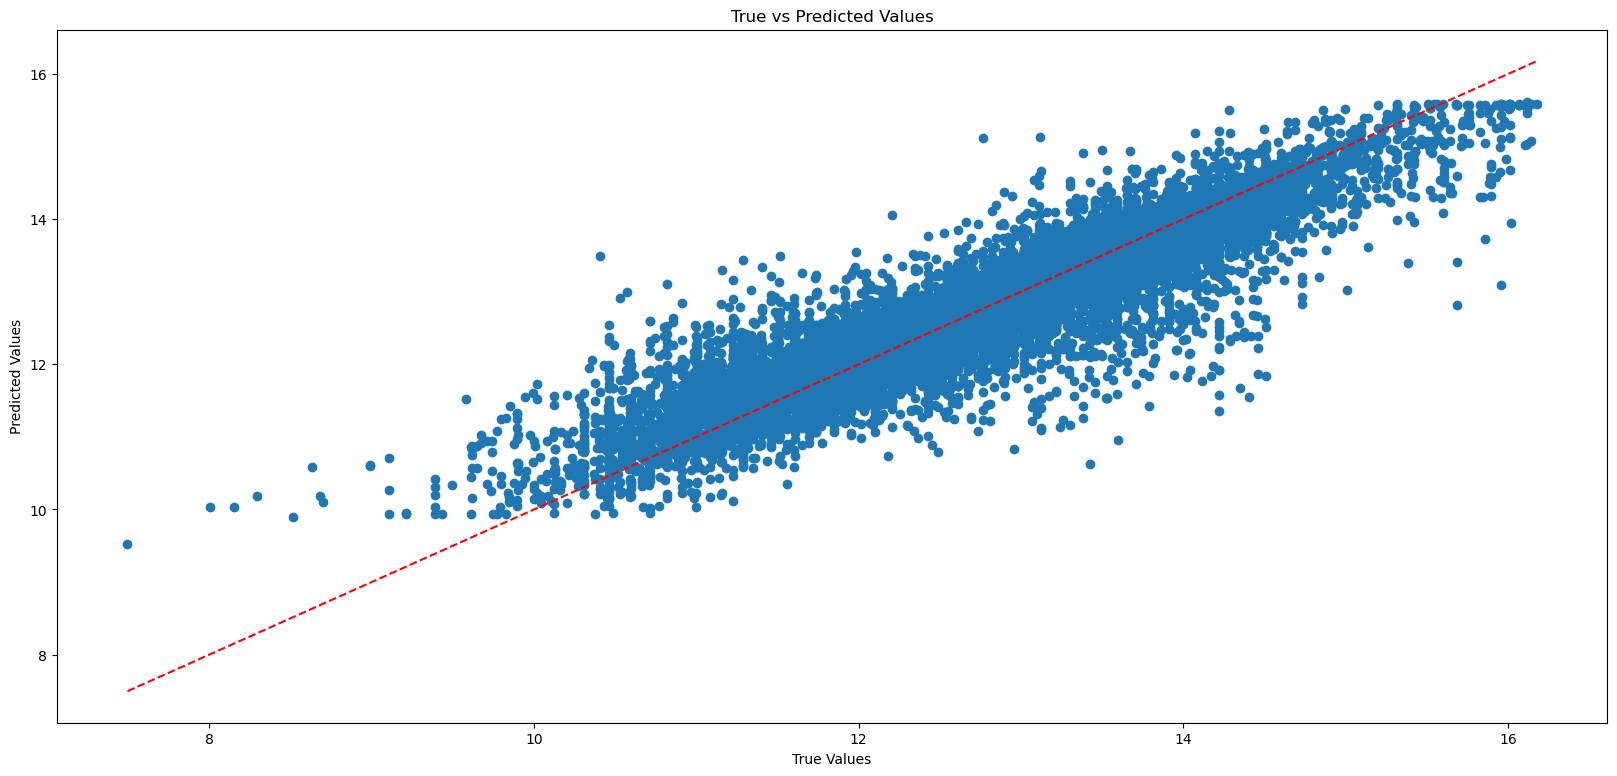

In [16]:
# график предсказанных значений против истинных значений
y_pred = model_sr_2.predict(X_test)
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

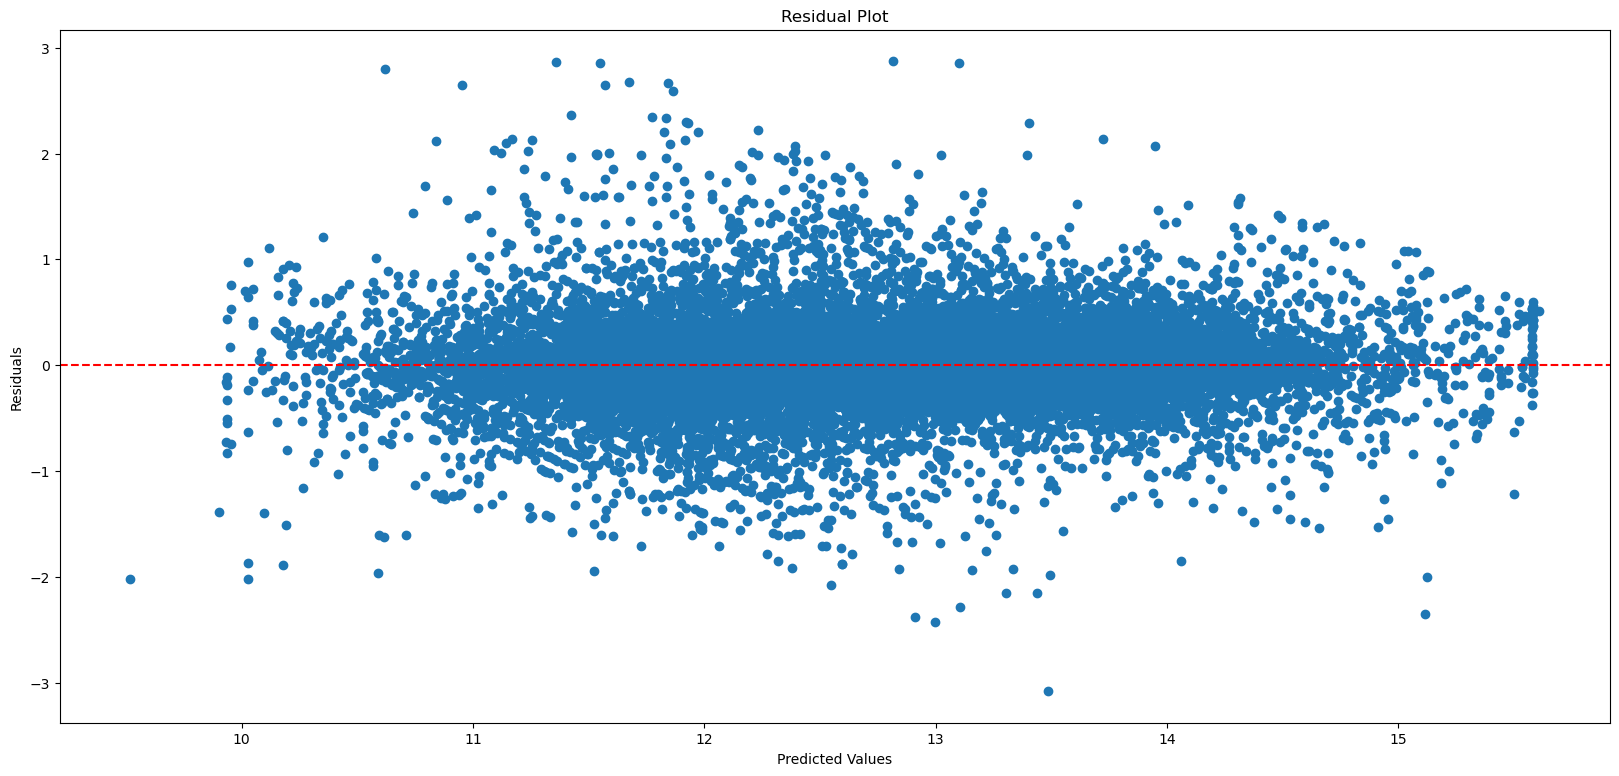

In [17]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()